# Matrix completion and recommender systems


[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:

- 100000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the `movielens.csv` file.


In [2]:
dataset = pd.read_csv("movielens.csv", sep="\t", header=None)
dataset.columns = ["user_id", "movie_id", "rating", "timestamp"]
dataset.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


How many movies? How many people? How many ratings?


In [3]:
n_movies = dataset["movie_id"].drop_duplicates().shape[0]
n_users = dataset["user_id"].drop_duplicates().shape[0]

Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).


In [4]:
np.random.seed(0)

idxs = np.arange(dataset.shape[0])
np.random.shuffle(idxs)

movies = dataset["movie_id"]
movies = movies[idxs]

users = dataset["user_id"]
users = users[idxs]

ratings = dataset["rating"]
ratings = ratings[idxs]

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.


In [5]:
# We use 80% of the data for training and 20% for testing
# We shift ids to start from 0, easier to deal with in matrices

n_training = int(0.8 * dataset.shape[0])

users_train = users[:n_training] - 1
movies_train = movies[:n_training] - 1
ratings_train = ratings[:n_training]

users_test = users[n_training:] - 1
movies_test = movies[n_training:] - 1
ratings_test = ratings[n_training:]

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:

$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$


In [6]:
X_sparse = csr_matrix((ratings_train, (users_train, movies_train)), shape=(n_users, n_movies))
X_full = X_sparse.toarray()

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:

$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$

where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):

$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$

and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):

$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$

where

$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$


In [7]:
avg_ratings = [np.mean(ratings_train[users_train == i]) for i in range(n_users)]

rating_prediction_baseline = [avg_ratings[i] for i in users_test]
error_baseline = rating_prediction_baseline-ratings_test

def RMSE(e):
    return np.sqrt(np.mean(e**2))

RMSE_baseline = RMSE(error_baseline)
rho_baseline = pearsonr(rating_prediction_baseline, ratings_test)[0]

print("Baseline RMSE: ", RMSE_baseline)
print("Baseline Pearson correlation: ", rho_baseline)

Baseline RMSE:  1.0510332730416247
Baseline Pearson correlation:  0.3706395766273629


# Singular value truncation (SVT) based recommender system


Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.


In [8]:
max_iter = 1000
threshold = 100
increment = 1e-3

RMSE_vt = []
rho_vt = []

X = np.copy(X_full)

for k in range(max_iter):
    X_old = np.copy(X)

    U,S,Vt = np.linalg.svd(X, full_matrices=False)
    #S = np.where(S > threshold, S, 0)
    S[S < threshold] = 0

    X = U @ np.diag(S) @ Vt
    X[users_train, movies_train] = X_full[users_train, movies_train]
    incr = np.linalg.norm(X - X_old,2)

    pred_ratings = X[users_test, movies_test]
    
    error = pred_ratings - ratings_test
    RMSE_vt.append(RMSE(error))
    rho_vt.append(pearsonr(pred_ratings, ratings_test)[0])

    print(f"Iteration {k}, RMSE: {RMSE_vt[-1]}, Pearson correlation: {rho_vt[-1]}, Increment: {incr}")

    if incr < increment:
        print(f"Convergence reached in {k} iterations")
        break

[513.47551191 199.75704098 177.7098562  131.00696448 129.69625813
 119.33552274 105.5542156  101.83227915   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0. 

KeyboardInterrupt: 

Text(0.5, 0.98, 'Singular Value Thresholding')

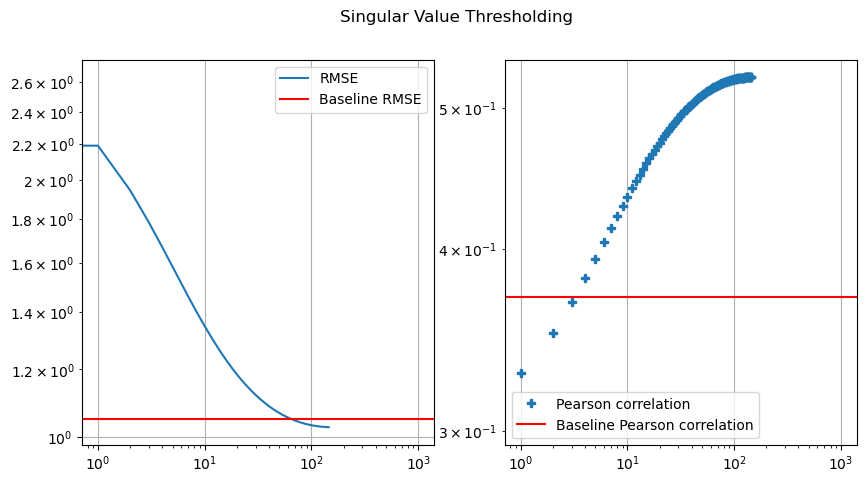

In [89]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].loglog(RMSE_vt,label="RMSE")
ax[0].axline([0, RMSE_baseline], [max_iter, RMSE_baseline], color="r", label="Baseline RMSE")
ax[0].legend()
ax[0].grid()

ax[1].loglog(rho_vt,"P",label="Pearson correlation")
ax[1].axline([0, rho_baseline], [max_iter, rho_baseline], color="r", label="Baseline Pearson correlation")
ax[1].legend()
ax[1].grid()

fig.suptitle("Singular Value Thresholding")